In [1]:
import scanpy as sc
import mudata as md
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scranPY
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

from scipy.sparse import csr_matrix

In [2]:
data_gex_ec = sc.read_h5ad(filename='../data/preprocessed/ec_prepro.h5ad')
data_gex_ec

AnnData object with n_obs × n_vars = 9639 × 3620
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_counts', 'louvain', 'size_factors'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'log1p', 'norm_counts', 'raw_counts', 'scran_norm', 'sqrt_counts'

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


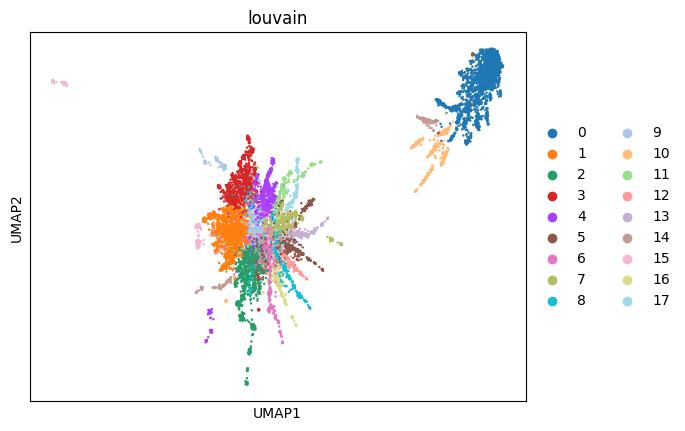

In [3]:
#Compute clusters for scran
data_gex_ec_pp = data_gex_ec.copy()

sc.pp.normalize_total(data_gex_ec_pp)
sc.pp.log1p(data_gex_ec_pp)
sc.pp.pca(data_gex_ec_pp, n_comps=15)
sc.pp.neighbors(data_gex_ec_pp, n_neighbors=80)
#sc.tl.leiden(data_gex_ec_pp, resolution=0.5, key_added="leiden")
sc.tl.louvain(data_gex_ec_pp, key_added="louvain")

sc.tl.umap(data_gex_ec_pp)
sc.pl.umap(data_gex_ec_pp, color=["louvain"])

In [4]:
data_gex_ec.obs["louvain"] = data_gex_ec_pp.obs["louvain"]
data_gex_ec.X = data_gex_ec.X.A
del(data_gex_ec_pp)

Current smallest cluster =  166  cells.
Using max_size =  3000 , clusters have been split into  18  clusters.
min_mean =  0.02


/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/scranPY/main.py:171: RuntimeWarning: divide by zero encountered in divide
  rescaling[clust] = np.nanmedian(cur_prof / ref_prof)


--- 1.16 mins ---
size factor min =  0.004109273389133751
size factor max =  27.359406310621566


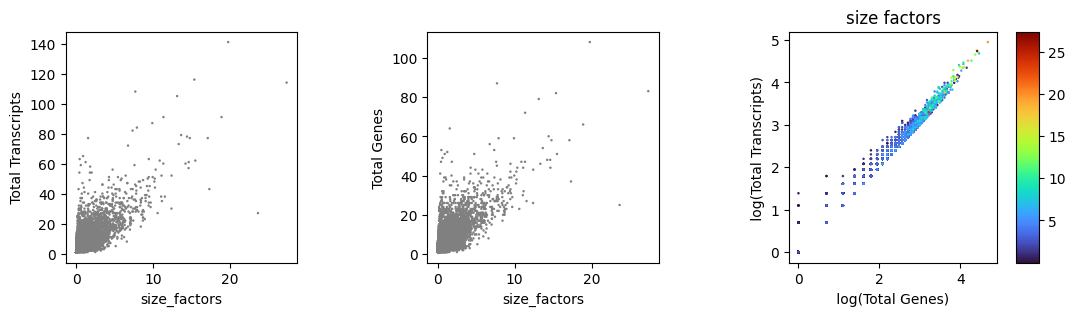

array([3.66546024, 0.38226349, 3.46978995, ..., 0.58382352, 1.22451801,
       3.51725653])

<Figure size 640x480 with 0 Axes>

In [5]:
scranPY.compute_sum_factors(data_gex_ec, clusters="louvain", parallelize=False, algorithm='CVXPY', 
   max_size=3000, min_mean=0.02, plotting=True, lower_bound=0.1, normalize_counts=False, log1p=False, layer='scranPY', 
   save_plots_dir=None, stopwatch=True)

In [6]:
#after scran matrix back to sparse
data_gex_ec.X = csr_matrix(data_gex_ec.X)

In [7]:
data_gex_ec.layers['scran_norm'] = sc.pp.log1p(data_gex_ec.X / data_gex_ec.obs.size_factors.to_numpy()[:, np.newaxis], copy=True)

Text(0.5, 0.98, 'E. Coli Normalization & VST')

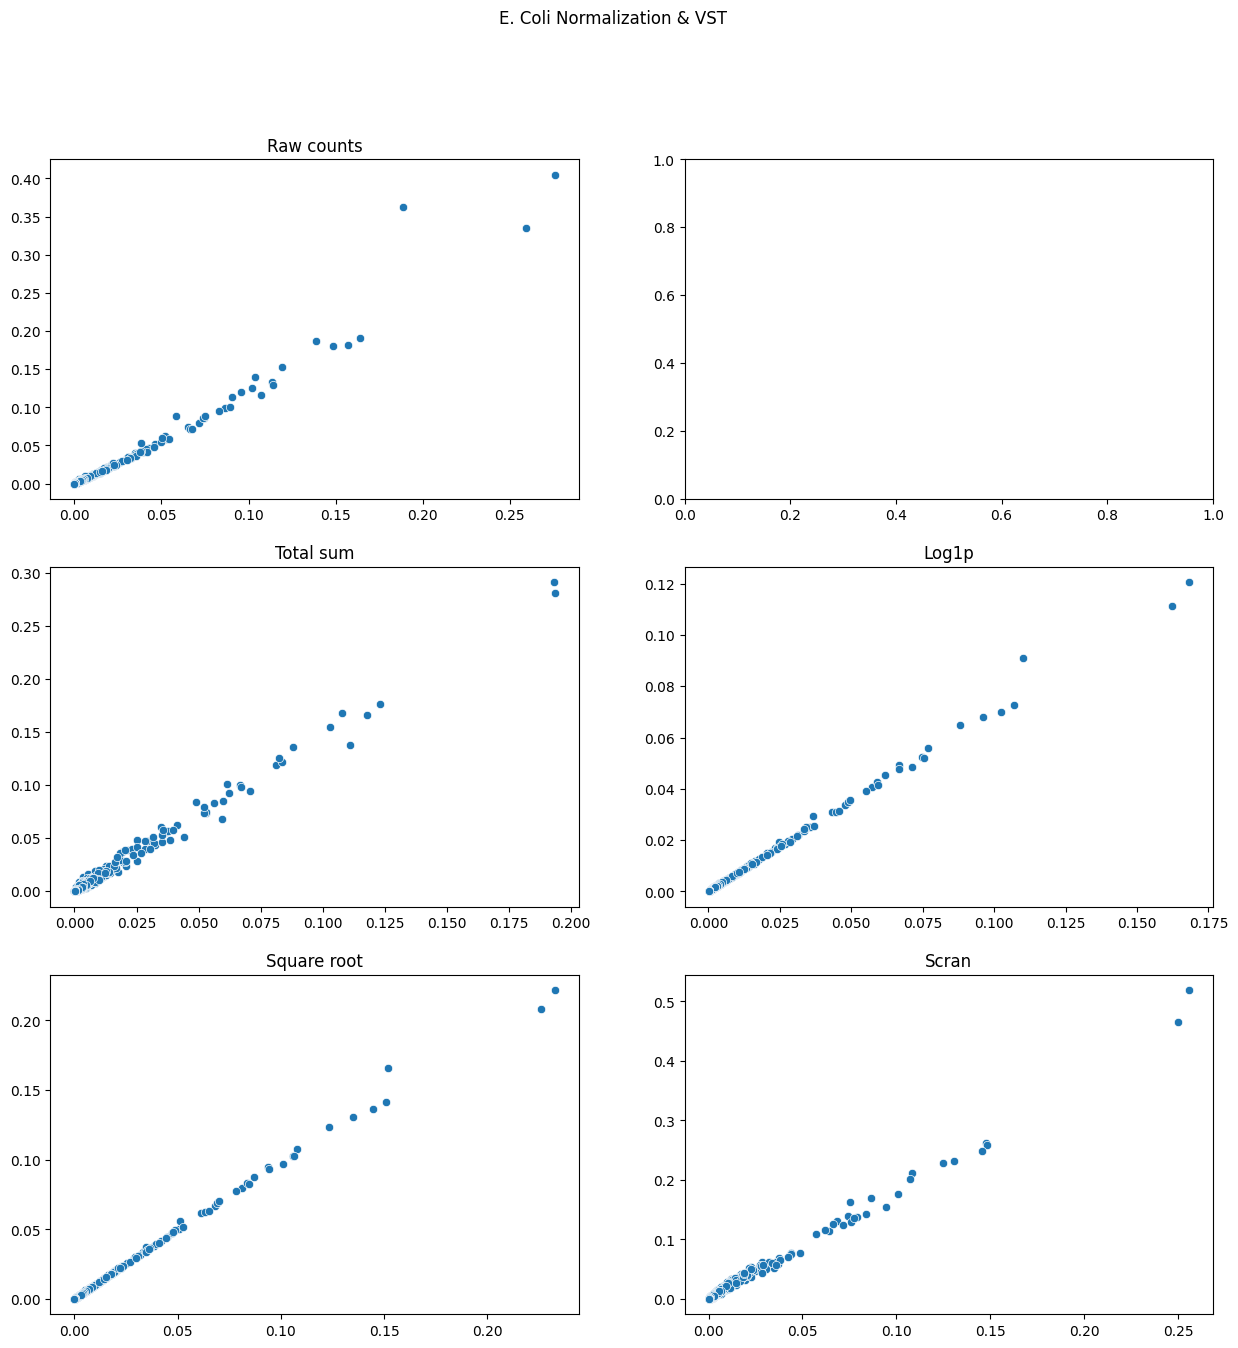

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(15,15))

sns.scatterplot(x=np.mean(data_gex_ec.X.A, axis=0), y=np.var(data_gex_ec.X.A, axis=0), ax=axes[0][0])

sns.scatterplot(x=np.mean(data_gex_ec.layers['norm_counts'].A, axis=0), 
                y=np.var(data_gex_ec.layers['norm_counts'].A, axis=0), 
                ax=axes[1][0])

sns.scatterplot(x=np.mean(data_gex_ec.layers['log1p'].A, axis=0), 
                y=np.var(data_gex_ec.layers['log1p'].A, axis=0), 
                ax=axes[1][1])

sns.scatterplot(x=np.mean(data_gex_ec.layers['sqrt_counts'].A, axis=0), 
                y=np.var(data_gex_ec.layers['sqrt_counts'].A, axis=0), 
                ax=axes[2][0])

sns.scatterplot(x=np.mean(data_gex_ec.layers['scran_norm'].A, axis=0), 
                y=np.var(data_gex_ec.layers['scran_norm'].A, axis=0), 
                ax=axes[2][1])


axes[0,0].set_title("Raw counts")
axes[1,0].set_title("Total sum")
axes[1,1].set_title("Log1p")
axes[2,0].set_title("Square root")
axes[2,1].set_title("Scran")
fig.suptitle("E. Coli Normalization & VST")